In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from statsmodels.tsa.seasonal import seasonal_decompose


plt.style.use('bmh')
color_pal=plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle=cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import pywt

In [2]:
# Read the data
cal_data = pd.read_csv('m5_data/calendar.csv')
sellp_data = pd.read_csv('m5_data/sell_prices.csv')
ss_data = pd.read_csv('m5_data/sample_submission.csv') 
salestv_data = pd.read_csv('m5_data/sales_train_validation.csv')

In [3]:
salestv_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [4]:
cal_data['date'] = pd.to_datetime(cal_data['date'])

In [5]:
ids = 0
d_cols = [i for i in salestv_data.columns if 'd_' in i]
example = salestv_data.loc[ids][d_cols].reset_index()
example.columns = ['d' , 'sales']
example = example.set_index('d').merge(cal_data.set_index('d')['date'], left_index=True, right_index=True)

date_calls = example[['date']]
date_calls['d_coll'] = example.index
date_calls.reset_index(drop=True, inplace=True)


example = example.set_index('date')

<Axes: xlabel='date'>

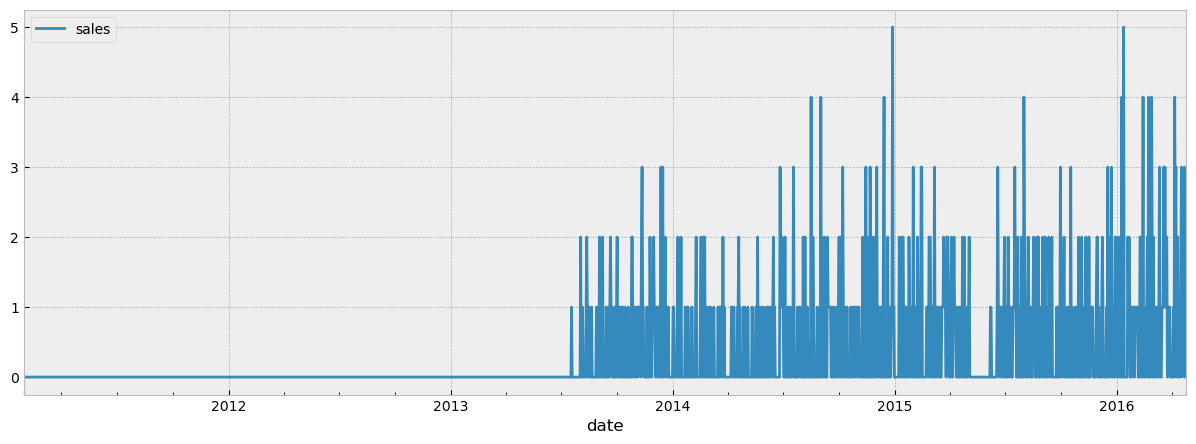

In [6]:
example.plot(figsize=(15,5))

In [7]:
example.index.inferred_freq

'D'

# Plotting Trend, seasonality, residual of a Time-series

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
#test1 = example[example.index > '2013-09-01']

In [10]:
result = seasonal_decompose(example, model='additive', period=365)

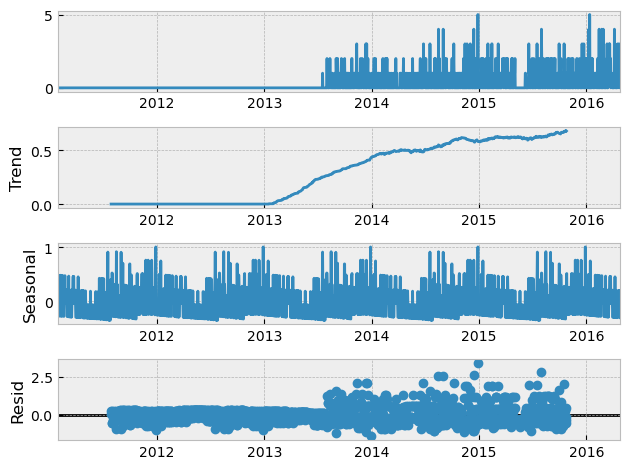

In [11]:
result.plot()
plt.show()

# Checking for Stationarity

1. Plotting rolling mean and variance is a good statistic to see if our series is stationary or non-stationary.
 * If rolling statistic show a clear trend (upward or downward)-***mean*** and show varying variance (increasing or decresing amplitude)-***std*** then, a series is possibly non-stationary

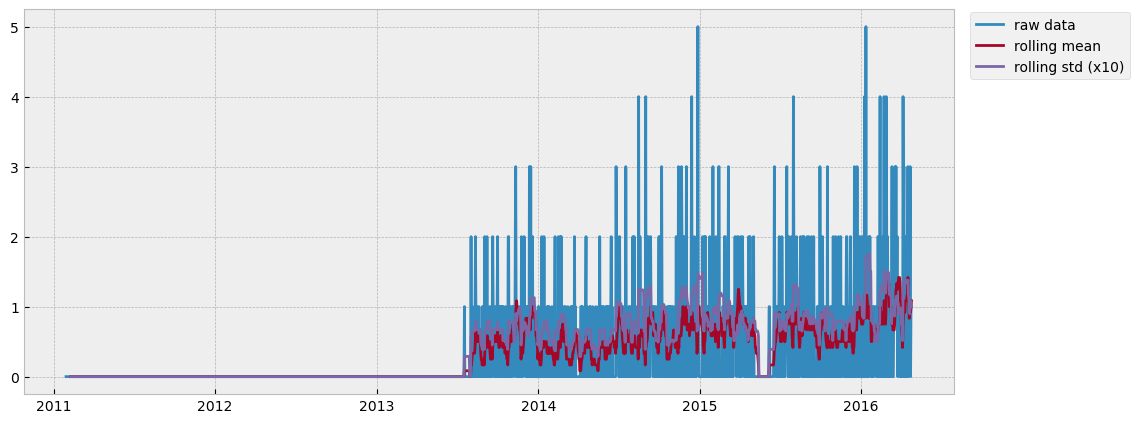

In [12]:
fig, ax = plt.subplots(1,figsize=(12, 5))
ax.plot(example.index, example.sales, label='raw data')
# Window of 12 is choosen as we have 12-period seasonality
ax.plot(example.sales.rolling(window=12).mean(), label="rolling mean") 
ax.plot(example.sales.rolling(window=12).std(), label="rolling std (x10)")
ax.legend(bbox_to_anchor=(1.01,1.01))

The series is non-stationry as can be seen by the above plot, both mean and variance are varying

2. Augmented Dickey-fuller test
    * This test will give a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not.

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def adfuller_test(data):
    print("Is the data stationary?")
    dftest = adfuller(data, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values:")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k,v,"not" if v<dftest[0] else "",100-int(k[:-1])))

In [15]:
adfuller_test(example.sales)

Is the data stationary?
Test statistic = -2.118
P-value = 0.237
Critical values:
	1%: -3.433814658052138 - The data is not stationary with 99% confidence
	5%: -2.8630704504871605 - The data is not stationary with 95% confidence
	10%: -2.56758475462613 - The data is not stationary with 90% confidence


The above value also proves that our series is non-stationary 

# Making series stationary

1. De-trending the series - We remove the trend in the series
    * In order to do that, we will create a de-trended column whose values are subtracted by rollng mean and divided by rolling variance

In [16]:
example['detrended_sales'] = (example['sales'] - example.sales.rolling(window=12).mean())/example.sales.rolling(window=12).std()

##### Performing rolling analysis and adfuller test to see if our de-trended series is stationary or not

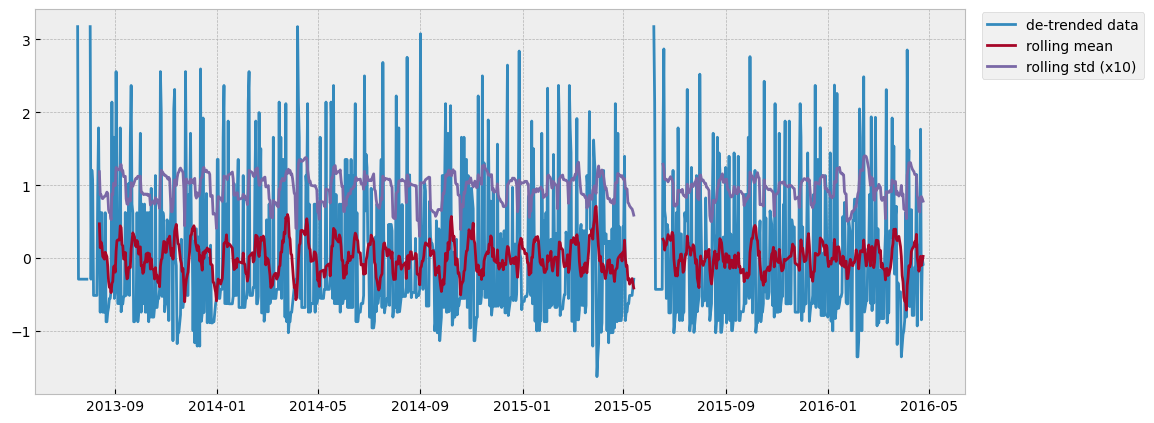

In [17]:
fig, ax = plt.subplots(1,figsize=(12, 5))
ax.plot(example.index, example.detrended_sales, label='de-trended data')
# Window of 12 is choosen as we have 12-period seasonality
ax.plot(example.detrended_sales.rolling(window=12).mean(), label="rolling mean") 
ax.plot(example.detrended_sales.rolling(window=12).std(), label="rolling std (x10)")
ax.legend(bbox_to_anchor=(1.01,1.01))

In [18]:
adfuller_test(example.detrended_sales.dropna())

Is the data stationary?
Test statistic = -11.284
P-value = 0.000
Critical values:
	1%: -3.437137538234527 - The data is  stationary with 99% confidence
	5%: -2.8645366106945414 - The data is  stationary with 95% confidence
	10%: -2.568365556798649 - The data is  stationary with 90% confidence


##### As it can be seen through both the above tests, our detrended series is free of trend but, we still have a seasonal component visible in the plotting analysis graph (the variance/std has an increasing decresing amplitude)

2. De-seasonling the series - We can do this by differencing which states, seasonal or cyclic patterns can be removed by subtracting periodical values (this subtraction is done on detrended series)
    * If data is 12-month seasonal, subtracting the series with a 12-lag difference series will give a "flatter" series 

In [19]:
example['deseasonal_sales'] = example['detrended_sales'] - example['detrended_sales'].shift(12)

##### Performing rolling analysis and adfuller test to see if our de-seasonal series is stationary or not

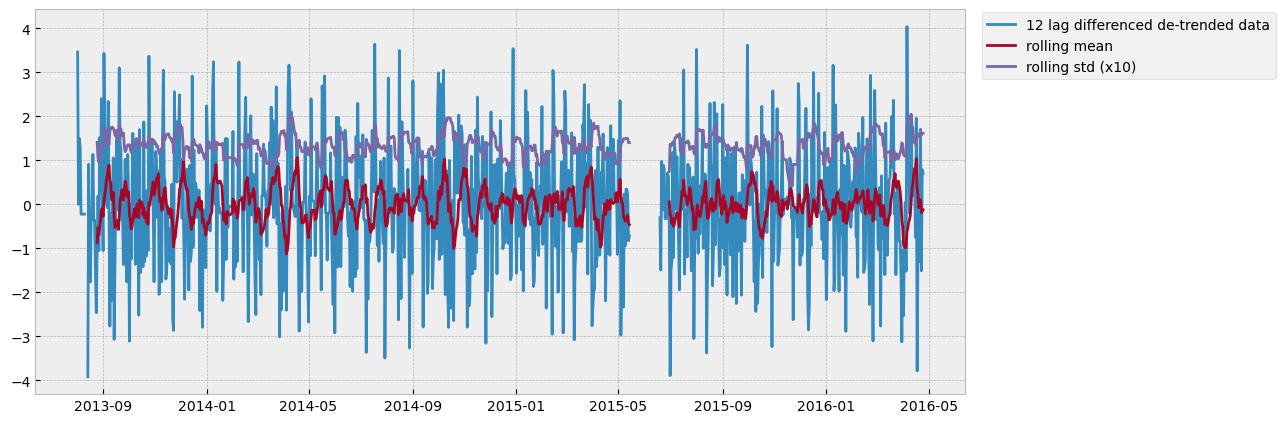

In [20]:
fig, ax = plt.subplots(1,figsize=(12, 5))
ax.plot(example.index, example.deseasonal_sales, label="12 lag differenced de-trended data")
ax.plot(example.deseasonal_sales.rolling(window=12).mean(), label="rolling mean");
ax.plot(example.deseasonal_sales.rolling(window=12).std(), label="rolling std (x10)");
ax.legend(bbox_to_anchor=(1.01, 1.01))


In [21]:
adfuller_test(example.deseasonal_sales.dropna())

Is the data stationary?
Test statistic = -12.961
P-value = 0.000
Critical values:
	1%: -3.437303541847512 - The data is  stationary with 99% confidence
	5%: -2.864609814371715 - The data is  stationary with 95% confidence
	10%: -2.5684045480287296 - The data is  stationary with 90% confidence


##### As it can be seen through both the above tests, our deseasonal series is free of trend and seasonality

# Autocorrelation plots (ACF & APCF)

***Lags*** = The amont by which we are shifting the time-series data to find correlations of current sales data with previous time-stamp sales data  
***Auto-Correlation*** = ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information  
***Partial Auto-Correlation*** = It finds the correlations in time-series by removing the indirect correlations as in AC 

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


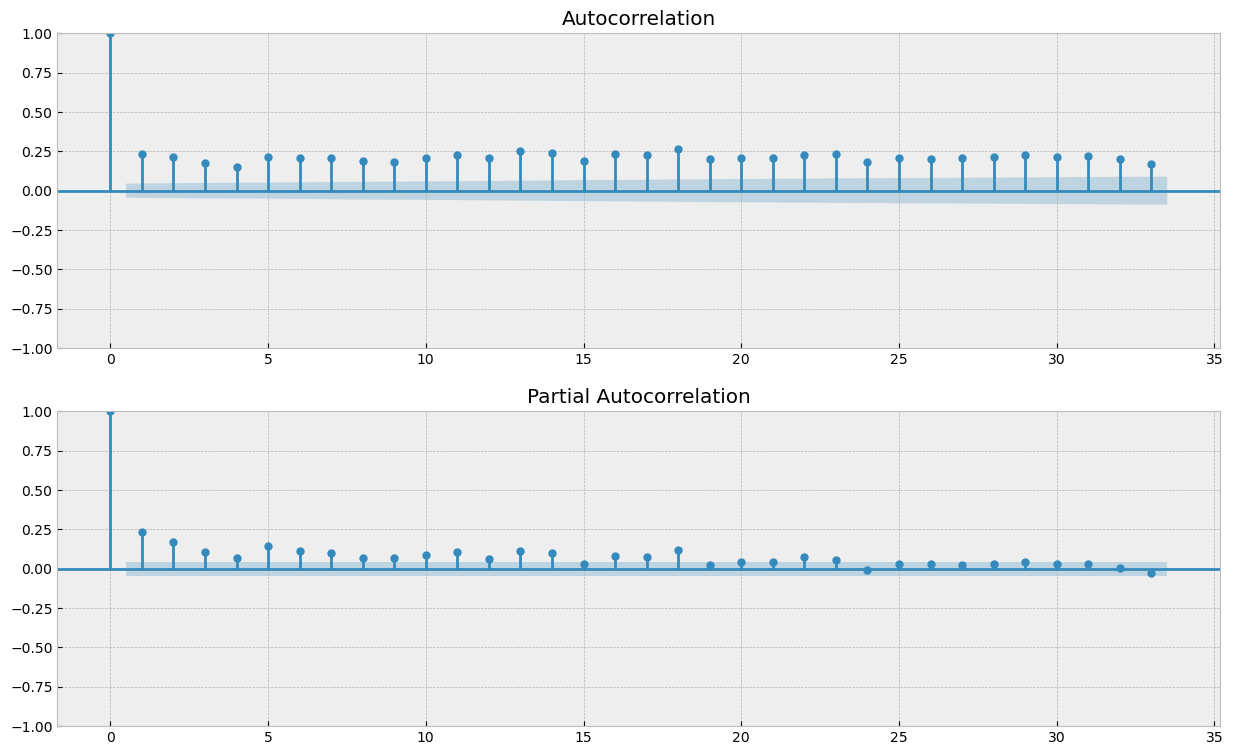

In [23]:
fig, ax = plt.subplots(2, figsize=(15,9))
ax[0] = plot_acf(example.sales.dropna(), ax=ax[0])
ax[1] = plot_pacf(example.sales.dropna(), ax=ax[1])

##### We can use ACF and PACF plot to get the AR(AutoRegression) term and MA(Moving Average) term respectively in ARMA model

* Identification of AR part is best done with PACF
    * For an AR part, the PACF "shuts off" past the order of model. "shuts off" theoratically means that the pacf is equal to 0 past that value

* Identification of MA part is best done with ACF
    * For an MA part, the pacf does not shut off, but is tampering around 0 in some manner. And the ACF plot has an exponential decrease rather than a sudden shut off as well

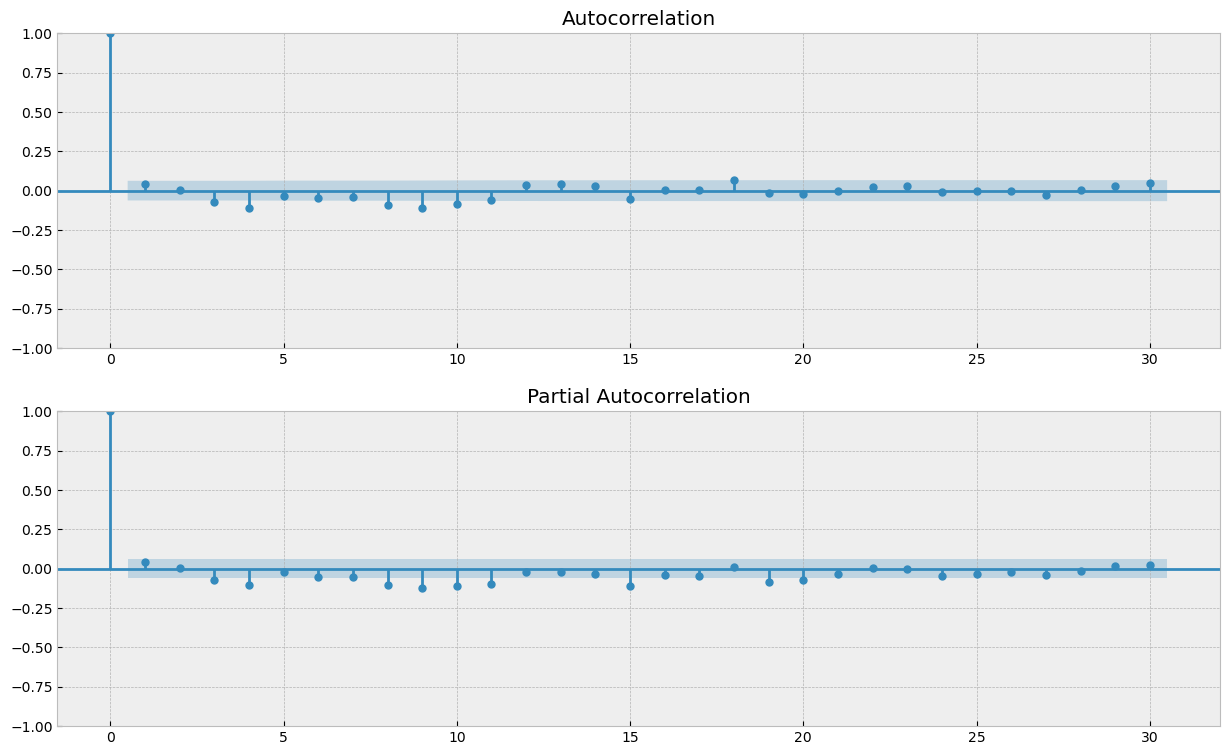

In [24]:
fig, ax = plt.subplots(2, figsize=(15,9))
ax[0] = plot_acf(example.detrended_sales.dropna(), ax=ax[0])
ax[1] = plot_pacf(example.detrended_sales.dropna(), ax=ax[1])

As per our plots, we can have ***AR to be 0 or 1*** and ***MA to be 1 or 2***

# Modeling

1. ARIMA model - AutoRegressive Integrated MovingAverage model
    * It has three components,
        * p - AR part
        * d - differencing part
        * q - MA part

##### Performing grid search to find the best parameters for ARIMA model 

!check the Minimum values!

In [25]:
import statsmodels.api as sm
import itertools

p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
aics = []
params = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        data = example['sales'].astype('int64').values
        model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=param_seasonal)
        result = model.fit()
        aics.append(result.aic)
        params.append((param, param_seasonal))
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))

index = aics.index(min(aics))
print("Minimum values: " + str(params[index]) + str(aics[index]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13585D+00    |proj g|=  1.76147D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     11      1     0     0   1.758D-05   1.136D+00
  F =   1.1358527987314864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4347.772807946667
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   3.555D-07   1.260D+00
  F =   1.2598146145451730     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4822.050715249832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.98861D-01    |proj g|=  1.63880D-01

At iterate    5    f=  9.64187D-01    |proj g|=  6.97373D-02


 This problem is unconstrained.



At iterate   10    f=  9.59891D-01    |proj g|=  1.81522D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   3.288D-06   9.599D-01
  F =  0.95989116283912701     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3676.5435890225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07266D+00    |proj g|=  8.86405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.97430D-01    |proj g|=  3.79324D-01

At iterate   10    f=  9.69565D-01    |proj g|=  3.03847D-03

At iterate   15    f=  9.68165D-01    |proj g|=  7.17248D-02

At iterate   20    f=  9.64255D-01    |proj g|=  2.62245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   2.262D-06   9.642D-01
  F =  0.96424919734812142     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3695.2174290539124
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4316.10929938076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00045D+00    |proj g|=  1.59032D-01

At iterate    5    f=  9.73738D-01    |proj g|=  6.40956D-02

At iterate   10    f=  9.59890D-01    |proj g|=  1.05181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   2.723D-05   9.599D-01
  F =  0.95988844490207559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08991D+00    |proj g|=  6.68243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   5.484D-06   1.089D+00
  F =   1.0888119274889581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06898D+00    |proj g|=  1.24693D-01

At iterate    5    f=  1.05810D+00    |proj g|=  1.03901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.875D-06   1.058D+00
  F =   1.0580954540081218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4054.273207035074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4318.074186571136
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05734D+00    |proj g|=  4.78350D-01


 This problem is unconstrained.



At iterate    5    f=  9.79746D-01    |proj g|=  3.99148D-02

At iterate   10    f=  9.58544D-01    |proj g|=  1.07174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   1.634D-05   9.585D-01
  F =  0.95848332297587946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3675.1571937057147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25561D+00    |proj g|=  6.01393D-04

           * 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35555D+00    |proj g|=  2.81881D-01

At iterate    5    f=  1.28776D+00    |proj g|=  6.87226D-02

At iterate   10    f=  1.26505D+00    |proj g|=  1.85987D-02

At iterate   15    f=  1.26397D+00    |proj g|=  2.54368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   4.966D-06   1.264D+00
  F =   1.2639633510310664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25491D+00    |proj g|=  2.21548D-02

At iterate    5    f=  1.25474D+00    |proj g|=  4.29436D-03

At iterate   10    f=  1.25398D+00    |proj g|=  1.96529D-02

At iterate   15    f=  1.25367D+00    |proj g|=  9.53586D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   9.536D-06   1.254D+00
  F =   1.2536719154715636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47276D+00    |proj g|=  5.88069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   2.172D-06   1.473D+00
  F =   1.4727386908377380     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:5638.698231145186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.31709D-01    |proj g|=  4.78615D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.291D-06   9.317D-01
  F =  0.93166889056286384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3570.565175293517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34524D+00    |proj g|=  9.40854D-02

At iterate    5    f=  1.28026D+00    |proj g|=  1.04831D-02


 This problem is unconstrained.



At iterate   10    f=  1.26346D+00    |proj g|=  1.37172D-02

At iterate   15    f=  1.26161D+00    |proj g|=  7.58558D-04

At iterate   20    f=  1.26137D+00    |proj g|=  5.90784D-05

At iterate   25    f=  1.26136D+00    |proj g|=  1.00912D-03

At iterate   30    f=  1.26136D+00    |proj g|=  3.86845D-05

At iterate   35    f=  1.26136D+00    |proj g|=  2.09109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     38     48      1     0     0   1.230D-05   1.261D+00
  F =   1.2613551560456033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4829.944827030

 This problem is unconstrained.



At iterate    5    f=  9.69127D-01    |proj g|=  4.07021D-02

At iterate   10    f=  9.42125D-01    |proj g|=  9.51774D-04

At iterate   15    f=  9.41873D-01    |proj g|=  9.70291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   1.116D-05   9.419D-01
  F =  0.94187310853275741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3609.60651324633
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:3570.567306695888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00924D+00    |proj g|=  1.23925D-01

At iterate    5    f=  9.49953D-01    |proj g|=  1.15784D-01

At iterate   10    f=  9.31710D-01    |proj g|=  4.93699D-03


 This problem is unconstrained.



At iterate   15    f=  9.31671D-01    |proj g|=  1.60427D-04

At iterate   20    f=  9.31668D-01    |proj g|=  2.96242D-03

At iterate   25    f=  9.31635D-01    |proj g|=  6.84862D-03

At iterate   30    f=  9.31586D-01    |proj g|=  2.68490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     57      1     0     0   2.396D-05   9.316D-01
  F =  0.93158593488285779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3572.247786861814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.16491D+00    |proj g|=  1.03708D-01

At iterate   10    f=  1.13319D+00    |proj g|=  9.38499D-03

At iterate   15    f=  1.12925D+00    |proj g|=  3.82558D-03

At iterate   20    f=  1.12886D+00    |proj g|=  1.39112D-04

At iterate   25    f=  1.12882D+00    |proj g|=  3.16450D-03

At iterate   30    f=  1.12881D+00    |proj g|=  1.85789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     47      1     0     0   1.858D-04   1.129D+00
  F =   1.1288126720615841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:4324.837283307

 This problem is unconstrained.



At iterate    5    f=  1.06036D+00    |proj g|=  2.50137D-01

At iterate   10    f=  9.46228D-01    |proj g|=  5.02212D-02

At iterate   15    f=  9.41824D-01    |proj g|=  5.91974D-04

At iterate   20    f=  9.41820D-01    |proj g|=  9.54414D-05

At iterate   25    f=  9.41819D-01    |proj g|=  5.66984D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   5.670D-06   9.418D-01
  F =  0.94181863796785603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3611.398108865017
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:4823.665401836167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05598D+00    |proj g|=  4.80232D-01


 This problem is unconstrained.



At iterate    5    f=  9.67919D-01    |proj g|=  1.14183D-01

At iterate   10    f=  9.58389D-01    |proj g|=  3.17693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   1.404D-05   9.584D-01
  F =  0.95838839668082065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:3672.79400570082
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:4026.628200930088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02923D+00    |proj g|=  1.02807D-01

At iterate    5    f=  9.82532D-01    |proj g|=  1.86229D-01

At iterate   10    f=  9.67361D-01    |proj g|=  3.47982D-03

At iterate   15    f=  9.64642D-01    |proj g|=  3.87186D-02

At iterate   20    f=  9.62343D-01    |proj g|=  1.66811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   9.891D-06   9.623D-01
  F =  0.96228996924090171     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.12705D+00    |proj g|=  1.65740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.123D-06   1.127D+00
  F =   1.1270453462923353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:4318.075494914475
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05701D+00    |proj g|=  4.77690D-01

At iterate    5    f=  9.79761D-01    |proj g|=  3.99832D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.73598D-01    |proj g|=  1.76420D-02

At iterate   10    f=  9.48269D-01    |proj g|=  1.02513D-01

At iterate   15    f=  9.34740D-01    |proj g|=  1.67738D-03

At iterate   20    f=  9.32383D-01    |proj g|=  7.32833D-04

At iterate   25    f=  9.32129D-01    |proj g|=  1.44429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   9.925D-06   9.321D-01
  F =  0.93212651292653381     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.24446D+00    |proj g|=  2.51313D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.322D-06   1.244D+00
  F =   1.2444470658729101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05609D+00    |proj g|=  4.80986D-01


 This problem is unconstrained.



At iterate    5    f=  9.68113D-01    |proj g|=  1.40837D-01

At iterate   10    f=  9.54639D-01    |proj g|=  3.27174D-03

At iterate   15    f=  9.51602D-01    |proj g|=  4.51850D-02

At iterate   20    f=  9.42195D-01    |proj g|=  9.63785D-03

At iterate   25    f=  9.40264D-01    |proj g|=  9.26629D-03

At iterate   30    f=  9.39980D-01    |proj g|=  2.54208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     42      1     0     0   3.234D-06   9.400D-01
  F =  0.93995145120583301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3604.254252313

 This problem is unconstrained.



At iterate   20    f=  9.33662D-01    |proj g|=  2.27443D-02

At iterate   25    f=  9.32231D-01    |proj g|=  1.45824D-04

At iterate   30    f=  9.32118D-01    |proj g|=  4.83390D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     36      1     0     0   8.058D-06   9.321D-01
  F =  0.93211765465524821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:3574.2821467109798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  9.61216D-01    |proj g|=  1.20946D-02

At iterate   10    f=  9.50459D-01    |proj g|=  2.13178D-02

At iterate   15    f=  9.40909D-01    |proj g|=  1.26519D-01

At iterate   20    f=  9.33980D-01    |proj g|=  9.86462D-03

At iterate   25    f=  9.32406D-01    |proj g|=  2.81651D-03

At iterate   30    f=  9.32178D-01    |proj g|=  1.32231D-03

At iterate   35    f=  9.32124D-01    |proj g|=  8.90285D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     56      1     0     0   8.834D-05   9.321D-01
  F =  0.93212392045525805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.12425D+00    |proj g|=  2.71158D-02

At iterate   10    f=  1.12272D+00    |proj g|=  8.90955D-04

At iterate   15    f=  1.12265D+00    |proj g|=  6.40922D-03

At iterate   20    f=  1.12205D+00    |proj g|=  6.89863D-03

At iterate   25    f=  1.12189D+00    |proj g|=  2.46885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   4.371D-06   1.122D+00
  F =   1.1218791591452244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:4300.309662889628
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  9.80320D-01    |proj g|=  4.35687D-02

At iterate   10    f=  9.54574D-01    |proj g|=  5.19493D-03

At iterate   15    f=  9.52668D-01    |proj g|=  2.73386D-02

At iterate   20    f=  9.45958D-01    |proj g|=  3.14200D-02

At iterate   25    f=  9.43298D-01    |proj g|=  2.07476D-02

At iterate   30    f=  9.40165D-01    |proj g|=  8.31543D-03

At iterate   35    f=  9.39997D-01    |proj g|=  8.49021D-04

At iterate   40    f=  9.39891D-01    |proj g|=  1.07542D-03

At iterate   45    f=  9.39891D-01    |proj g|=  3.58739D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     74      2     0     0   6.660D-05   9.399D-01
  F =  0.93989071385857592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3606.0218712229116
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11972D+00    |proj g|=  7.22660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   4.645D-06   1.470D+00
  F =   1.4698826816638291     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:5627.77114004581
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25425D+00    |proj g|=  4.11262D-01


 This problem is unconstrained.



At iterate    5    f=  1.16638D+00    |proj g|=  1.29924D-01

At iterate   10    f=  1.13050D+00    |proj g|=  4.08787D-03

At iterate   15    f=  1.12809D+00    |proj g|=  2.36525D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   4.961D-06   1.128D+00
  F =   1.1280675052751339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:4321.986275182662
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11932D+00    |proj g|=  2.22562D-03

At iterate   10    f=  1.11899D+00    |proj g|=  1.13484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   5.328D-06   1.119D+00
  F =   1.1188778865184272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:4288.826793819502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35170D+00    |proj g|=  2.24559D-01


 This problem is unconstrained.



At iterate    5    f=  1.33448D+00    |proj g|=  2.51278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.052D-07   1.334D+00
  F =   1.3344838765434044     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:5111.735311655065
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29761D+00    |proj g|=  3.28058D-01


 This problem is unconstrained.



At iterate    5    f=  1.17359D+00    |proj g|=  2.42167D-01

At iterate   10    f=  1.12813D+00    |proj g|=  8.48103D-03

At iterate   15    f=  1.12737D+00    |proj g|=  3.12150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.874D-06   1.127D+00
  F =   1.1273664311623688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:4321.303965627223
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:3569.944658404139
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.45344D-01    |proj g|=  1.29876D-01

At iterate   10    f=  9.31517D-01    |proj g|=  1.53948D-03

At iterate   15    f=  9.31494D-01    |proj g|=  1.48641D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   1.486D-06   9.315D-01
  F =  0.93149405580088385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:3571.8962574941816
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  1.26148D+00    |proj g|=  6.57302D-03

At iterate   20    f=  1.26128D+00    |proj g|=  9.92108D-04

At iterate   25    f=  1.26126D+00    |proj g|=  2.05109D-03

At iterate   30    f=  1.26126D+00    |proj g|=  2.07585D-04

At iterate   35    f=  1.26126D+00    |proj g|=  3.77065D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     46      1     0     0   2.870D-06   1.261D+00
  F =   1.2612609560387817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:4831.584417804379


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15384D+00    |proj g|=  4.89203D-01

At iterate    5    f=  9.92696D-01    |proj g|=  2.37366D-01

At iterate   10    f=  9.42085D-01    |proj g|=  1.37878D-02

At iterate   15    f=  9.41813D-01    |proj g|=  9.10297D-04

At iterate   20    f=  9.41723D-01    |proj g|=  2.00912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   8.261D-06   9.417D-01
  F =  0.94171415984806794     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  9.31517D-01    |proj g|=  8.70260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   5.751D-06   9.315D-01
  F =  0.93149482635438519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:3571.8992056318775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01189D+00    |proj g|=  1.16076D-01


 This problem is unconstrained.



At iterate    5    f=  9.60732D-01    |proj g|=  2.08535D-01

At iterate   10    f=  9.31766D-01    |proj g|=  7.08585D-03

At iterate   15    f=  9.31498D-01    |proj g|=  1.05605D-04

At iterate   20    f=  9.31498D-01    |proj g|=  8.64430D-04

At iterate   25    f=  9.31469D-01    |proj g|=  8.49966D-03

At iterate   30    f=  9.31404D-01    |proj g|=  2.82630D-04

At iterate   35    f=  9.31404D-01    |proj g|=  3.95200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     54      1     0     0   3.952D-05   9.314D-01
  F =  0.93140359944677420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.15499D+00    |proj g|=  4.49954D-02

At iterate   10    f=  1.13280D+00    |proj g|=  6.19064D-03

At iterate   15    f=  1.12911D+00    |proj g|=  3.46414D-03

At iterate   20    f=  1.12884D+00    |proj g|=  1.33206D-03

At iterate   25    f=  1.12881D+00    |proj g|=  5.06385D-04

At iterate   30    f=  1.12881D+00    |proj g|=  2.48867D-04

At iterate   35    f=  1.12880D+00    |proj g|=  6.89789D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     42      1     0     0   6.898D-05   1.129D+00
  F =   1.1288047032837432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.05588D+00    |proj g|=  1.83708D-01

At iterate   10    f=  9.46809D-01    |proj g|=  8.38924D-02

At iterate   15    f=  9.41675D-01    |proj g|=  7.02822D-04

At iterate   20    f=  9.41674D-01    |proj g|=  4.16787D-04

At iterate   25    f=  9.41660D-01    |proj g|=  4.26498D-03

At iterate   30    f=  9.41654D-01    |proj g|=  1.22526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   1.232D-05   9.417D-01
  F =  0.94165373646208816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:3612.767195703

##### Fitting the model after finding the best possible parameter values

In [26]:
data = example['sales'].astype('int64')
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,0,0,12), 
                                  enforce_stationarity=False, enforce_invertibility=False)
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00861D+00    |proj g|=  2.55905D-01

At iterate    5    f=  9.31054D-01    |proj g|=  7.74390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     19      1     0     0   4.294D-06   9.311D-01
  F =  0.93105236494761823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observati

/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


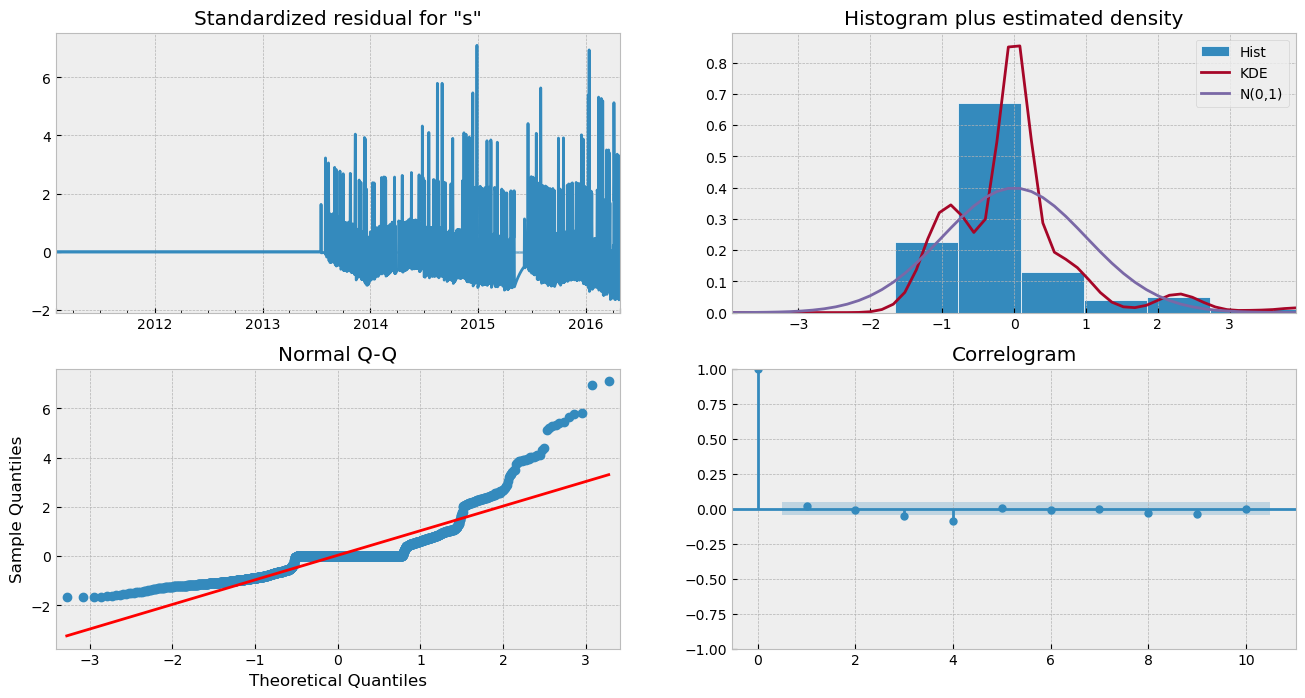

In [27]:
result.plot_diagnostics(figsize=(16,8))
plt.show()

##### Validating forecast

Printing the sales of last 200 days to have a better look at the data and the generated predictions by ARIMA.

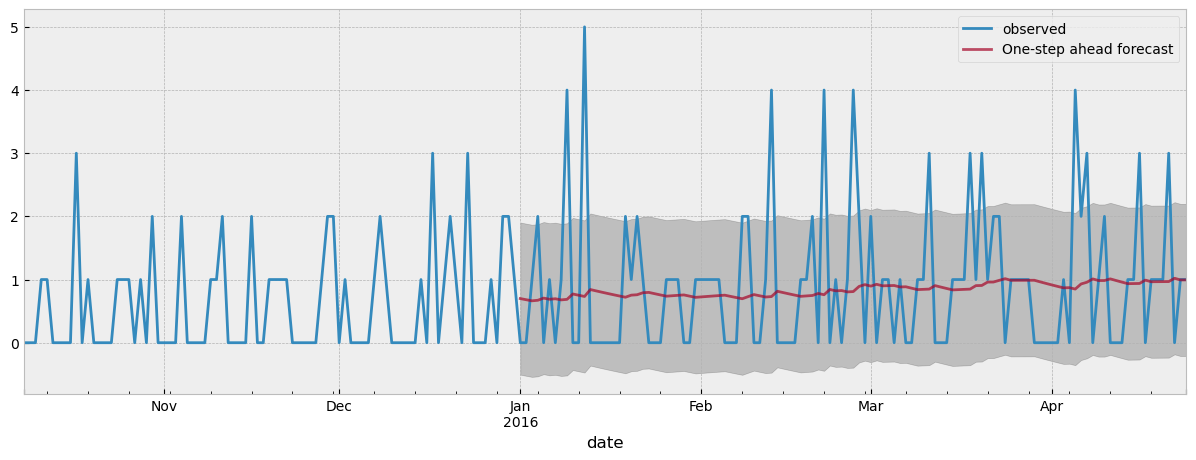

In [28]:
pred = result.get_prediction(start='2016-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax=example['sales'][-200:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=0.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

Calculating RMSE

In [29]:
y_forecasted = pred.predicted_mean
y_truth = data['2016-01-01':]

In [30]:
rmse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(np.sqrt(rmse), 2))

The Mean Squared Error of our forecasts is 1.142842853002671


# Prophet single shot on same product to compare

In [31]:
import fbprophet 
from fbprophet import Prophet
import time

In [32]:
salestv_data.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = salestv_data.T  # seting the days as index for new dataframe(Data)
data.columns = salestv_data['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = cal_data['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data

id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
2016-04-21,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
2016-04-22,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0


In [33]:
#HOBBIES_1_001_CA_1_validation
start_interval = 946 # removing the intial interval where no sold item data is shown
test_sample= 114
train_prophet = data[['HOBBIES_1_001_CA_1_validation']][start_interval:-test_sample].astype('float')
true = data['HOBBIES_1_001_CA_1_validation'][-test_sample:].astype('float')

In [34]:
# prepare dataframe for fprophet model
train_prophet['ds'] = train_prophet.index.values
train_prophet.rename(columns={'HOBBIES_1_001_CA_1_validation':'y'},inplace=True)
train_prophet = train_prophet[['ds','y']]
train_prophet.columns.name = None
train_prophet

,ds,y
date,,
2013-09-01,2013-09-01,0.0
2013-09-02,2013-09-02,2.0
2013-09-03,2013-09-03,1.0
2013-09-04,2013-09-04,0.0
2013-09-05,2013-09-05,0.0
...,...,...
2015-12-28,2015-12-28,0.0
2015-12-29,2015-12-29,2.0
2015-12-30,2015-12-30,2.0


In [35]:
#fprophet model without holidays
start_time = time.time()
m = Prophet(yearly_seasonality=True)
m.fit(train_prophet)

future = m.make_future_dataframe(periods=114)
forecast = m.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

duration = time.time() - start_time
print(f'training is done within:{duration} minutes')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       1159.11   0.000436462       93.9982   4.038e-06       0.001      127  LS failed, Hessian reset 
      99       1159.13   3.66212e-07       82.2557      0.5664      0.5664      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1159.13   8.31245e-06       93.3342   8.518e-08       0.001      225  LS failed, Hessian reset 
     143       1159.13   1.40936e-08       89.4584      0.1753      0.4825      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training is done within:1.9370720386505127 minutes


In [36]:
import math
prophet_Rmse = []
for i in np.arange(1,115,1):
    prophet_rmse = math.sqrt(sum(pow((predicted_prophet.yhat[:i] - true[:i]),2))/len(true[:i]))
    prophet_Rmse.append(prophet_rmse)
prophet_Rmse
p_rmse = sum(prophet_Rmse)/len(prophet_Rmse)

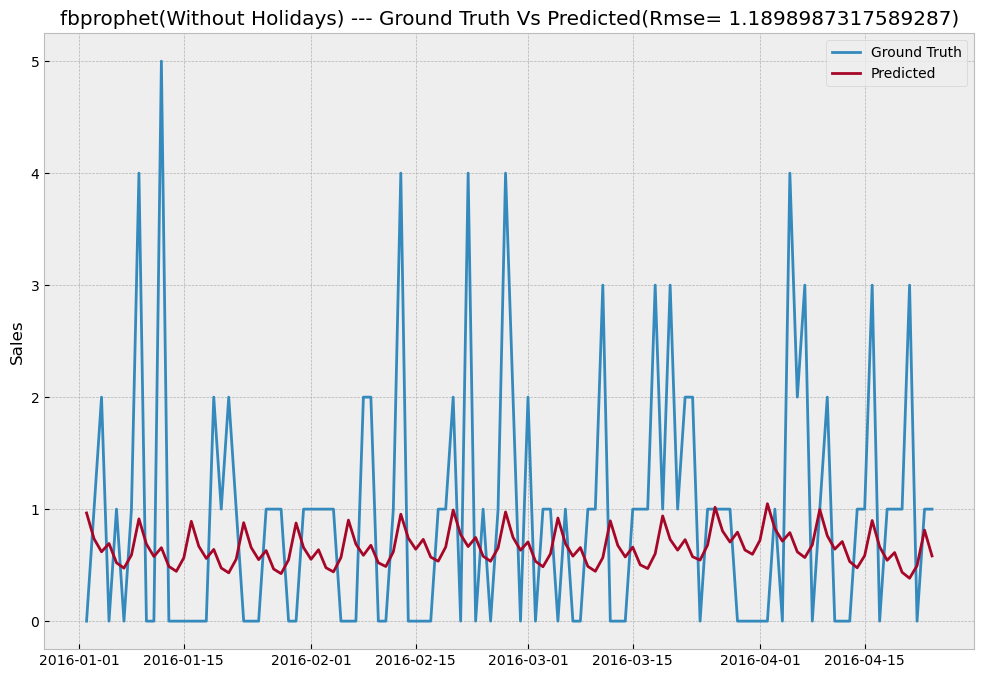

In [37]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(predicted_prophet, label='Predicted')
plt.title('fbprophet(Without Holidays) --- Ground Truth Vs Predicted(Rmse= {})'.format(p_rmse))
plt.ylabel('Sales')
plt.legend()

In [38]:
holidays = cal_data[cal_data['event_type_1'].isnull() == False]
holidays = holidays[['date','event_name_1', 'event_type_1']]
holidays.rename(columns={'date':'ds','event_name_1':'holiday'},inplace=True)

start_time = time.time()

m_holi = Prophet(yearly_seasonality=True,holidays=holidays)
m_holi.fit(train_prophet)

future = m_holi.make_future_dataframe(periods=114)
forecast = m_holi.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

print(f'training is done within:{duration} minutes')


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/fbprophet/forecaster.py:891

Initial log joint probability = -18.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1183.26   8.60752e-05       96.8741           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       1183.27   8.63902e-10       86.7603   0.0002845      0.1801      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
training is done within:1.9370720386505127 minutes


In [39]:
prophet_Rmse = []
for i in np.arange(1,115,1):
    prophet_rmse = math.sqrt(sum(pow((predicted_prophet.yhat[:i] - true[:i]),2))/len(true[:i]))
    prophet_Rmse.append(prophet_rmse)
prophet_Rmse
p_rmse = sum(prophet_Rmse)/len(prophet_Rmse)

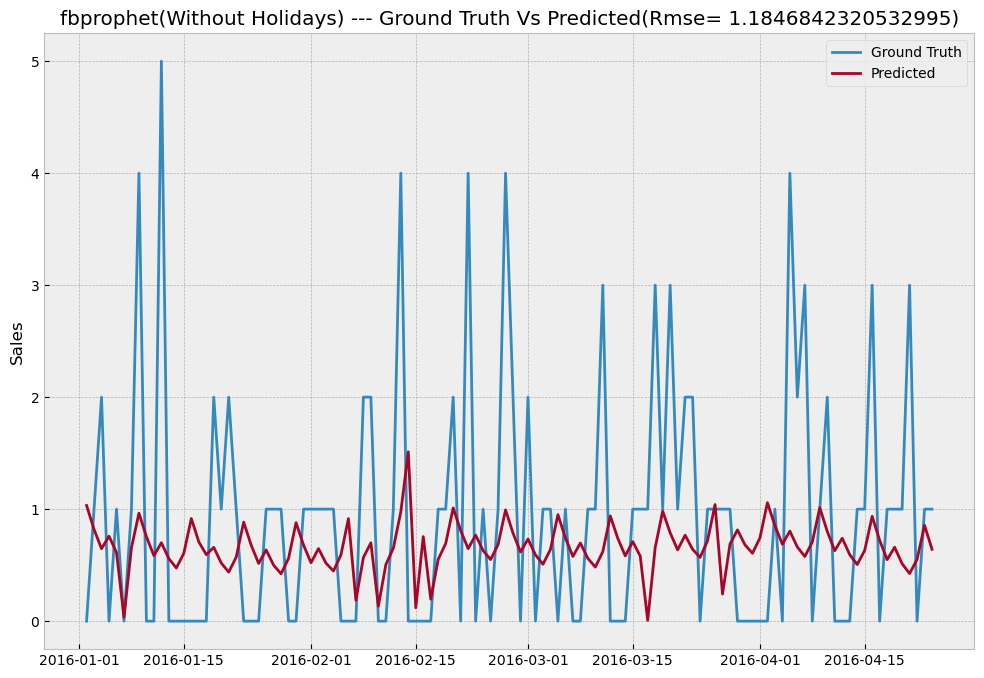

In [40]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(predicted_prophet, label='Predicted')
plt.title('fbprophet(Without Holidays) --- Ground Truth Vs Predicted(Rmse= {})'.format(p_rmse))
plt.ylabel('Sales')
plt.legend()

As it can be seen through the graph, the SARIMA and prophet models did not really do very well for our data.

Continue with more details in next notebook.